# How to read and process modeldata that is not in AeroCom convention

**Short answer**: skip `ReadGridded` and find the file you want to read and put it in `GriddedData` directly.

In [1]:
import pyaerocom as pya
from warnings import filterwarnings
filterwarnings('ignore')
pya.__version__

'0.8.1.dev3'

In [2]:
pya.const.BASEDIR = '/home/notebook/shared-ns1000k/inputs/pyaerocom-testdata/'

Initiating directories for pyaerocom test dataset


In [3]:
CMIP6_TEST_DIR = '/home/notebook/shared-cmip6-for-ns1000k/hist-aer/HadGEM3-GC31-LL/r1i1p1f3/'
CMIP6_TEST_FILE = 'od550aer_AERmon_HadGEM3-GC31-LL_hist-aer_r1i1p1f3_gn_195001-202012.nc'

In [4]:
path = CMIP6_TEST_DIR + CMIP6_TEST_FILE
modeldata = pya.GriddedData(path, var_name='od550aer')

In [5]:
modeldata.metadata['ts_type'] = 'monthly' # needed for colocation
modeldata.ts_type

'monthly'

In [6]:
modeldata.start

numpy.datetime64('1950-01-01T00:00:00.000000')

In [7]:
modeldata.stop

numpy.datetime64('2020-12-31T23:59:59.999999')

In [8]:
obsdata = pya.io.ReadUngridded().read('AeronetSunV3Lev2.daily', 'od550aer')

In [9]:
coldata = pya.colocation.colocate_gridded_ungridded(modeldata, obsdata, ts_type='monthly', start=2010)

Setting od550aer outlier lower lim: -1.00
Setting od550aer outlier upper lim: 10.00
Interpolating data of shape (132, 144, 192). This may take a while.
Successfully interpolated cube


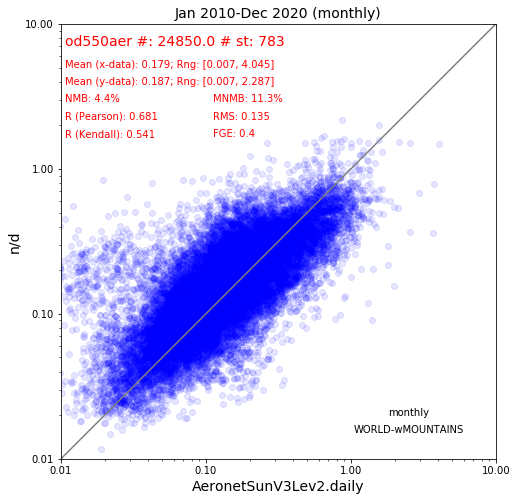

In [10]:
coldata.plot_scatter(marker='o', color='blue', alpha=0.1);

In [11]:
coldata.calc_statistics()

{'totnum': 103356.0,
 'num_valid': 24850.0,
 'refdata_mean': 0.17935390127175505,
 'refdata_std': 0.1813866417852069,
 'data_mean': 0.1872799765563362,
 'data_std': 0.1493421064145426,
 'rms': 0.13545354638023102,
 'R': 0.6814536729124887,
 'R_spearman': 0.7246224563765227,
 'R_kendall': 0.5414586532324707,
 'nmb': 0.044192377352147164,
 'mnmb': 0.11311652633467156,
 'fge': 0.4095399238610783,
 'num_neg_data': 0,
 'num_neg_refdata': 0,
 'num_coords_with_data': 783,
 'num_coords_tot': 783}

## Trend in bias ?

**NOTE**: the following code may not work for you due to memory requirements ([we will work on this](https://github.com/metno/pyaerocom/issues/53))

In [12]:
import numpy as np
years = np.arange(2000, 2019)
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [13]:
from IPython.display import clear_output
nmb_result = []
for year in years:
    clear_output()
    print('Processing year {}'.format(year))
    try:
        _coldata = pya.colocation.colocate_gridded_ungridded(modeldata, obsdata, 
                                                             ts_type='monthly', 
                                                             start=year)
        _stats = _coldata.calc_statistics()
        nmb_result.append(_stats['nmb'])
    except Exception as e:
        nmb_result.append(np.nan)
        print('Colocating failed. Reason: {}'.format(repr(e)))

Processing year 2018


Setting od550aer outlier lower lim: -1.00
Setting od550aer outlier upper lim: 10.00
Interpolating data of shape (36, 144, 192). This may take a while.
Successfully interpolated cube


In [22]:
tidx = [pya.helpers.to_datetime64(x) for x in years]
tidx

[numpy.datetime64('2000-01-01T00:00:00.000000000'),
 numpy.datetime64('2001-01-01T00:00:00.000000000'),
 numpy.datetime64('2002-01-01T00:00:00.000000000'),
 numpy.datetime64('2003-01-01T00:00:00.000000000'),
 numpy.datetime64('2004-01-01T00:00:00.000000000'),
 numpy.datetime64('2005-01-01T00:00:00.000000000'),
 numpy.datetime64('2006-01-01T00:00:00.000000000'),
 numpy.datetime64('2007-01-01T00:00:00.000000000'),
 numpy.datetime64('2008-01-01T00:00:00.000000000'),
 numpy.datetime64('2009-01-01T00:00:00.000000000'),
 numpy.datetime64('2010-01-01T00:00:00.000000000'),
 numpy.datetime64('2011-01-01T00:00:00.000000000'),
 numpy.datetime64('2012-01-01T00:00:00.000000000'),
 numpy.datetime64('2013-01-01T00:00:00.000000000'),
 numpy.datetime64('2014-01-01T00:00:00.000000000'),
 numpy.datetime64('2015-01-01T00:00:00.000000000'),
 numpy.datetime64('2016-01-01T00:00:00.000000000'),
 numpy.datetime64('2017-01-01T00:00:00.000000000'),
 numpy.datetime64('2018-01-01T00:00:00.000000000')]

Text(0.5,1,'Evolution of AOD bias in model (vs. AERONET)')

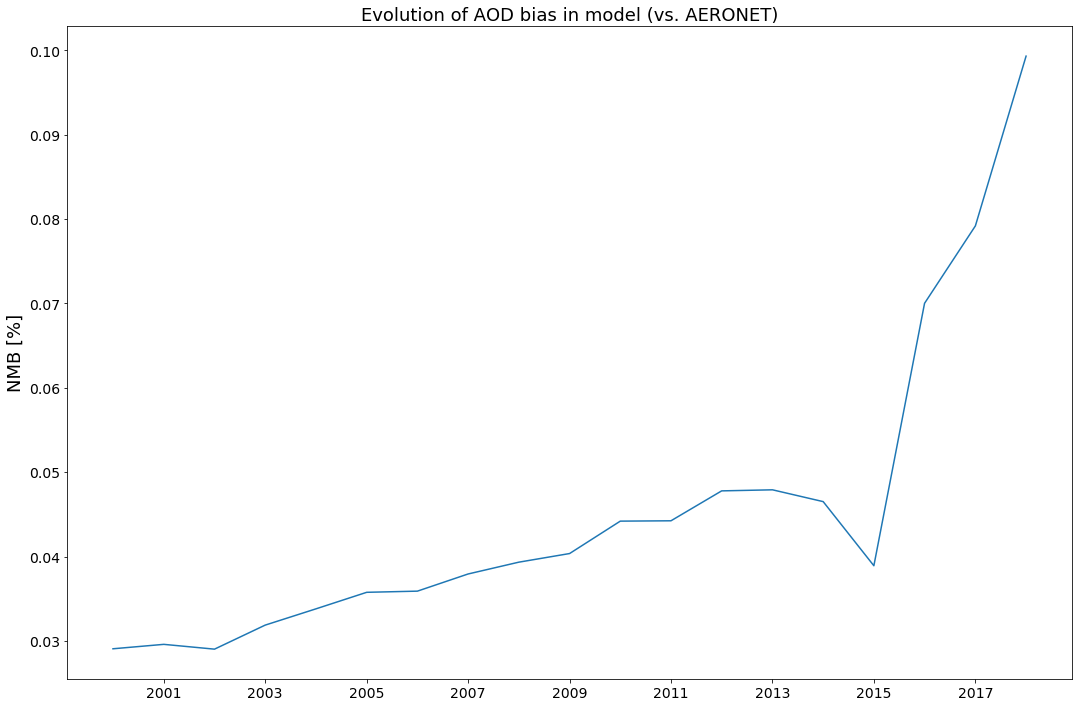

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(18, 12))
ax.plot(tidx, nmb_result);
ax.set_ylabel('NMB [%]')
ax.set_title('Evolution of AOD bias in model (vs. AERONET)')